# 시스템 품질 변화로 인한 사용자 불편 예지 AI 

## 라이브러리 가져오기

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 날짜 포맷
import datetime as dt

In [2]:
base_path = "./data/"
test_err = pd.read_csv(base_path + "test_err_data.csv")
test_qual = pd.read_csv(base_path + "test_quality_data.csv", thousands=',')
train_err = pd.read_csv(base_path + "train_err_data.csv")
train_prob = pd.read_csv(base_path + "train_problem_data.csv")
train_qual = pd.read_csv(base_path + "train_quality_data.csv", thousands=',')

## Data Preprocessing

In [52]:
def make_datetime(x): # datetime 데이터로 변환
        x = str(x)
        year  = int(x[:4])
        month = int(x[4:6])
        day   = int(x[6:8])
        hour  = int(x[8:10])
        minute  = int(x[10:12])
        sec  = int(x[12:])
        return dt.datetime(year, month, day, hour, minute, sec)

In [53]:
train_err.time = train_err.time.apply(lambda x : make_datetime(x))

In [54]:
train_qual = train_qual.sort_values(['user_id','time']).reset_index(drop=True)
train_qual.time = train_qual.time.apply(lambda x : make_datetime(x))

In [55]:
train_prob = train_prob.sort_values(['user_id','time']).reset_index(drop=True)
train_prob.time = train_prob.time.apply(lambda x : make_datetime(x))

In [56]:
test_err.time = test_err.time.apply(lambda x : make_datetime(x))

In [57]:
test_qual.time = test_qual.time.apply(lambda x : make_datetime(x))

In [58]:
train_qual

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
1,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
2,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
3,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
4,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788539,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,1.0,0,0,0,0,17,0,0
788540,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,0.0,0,0,0,0,17,0,0
788541,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,3.0,0,0,0,0,17,0,0
788542,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,0.0,0,0,0,0,17,0,0


### Train Error Data 분석

In [59]:
train_err.shape # 16554663, 6
train_err.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype         
---  ------    -----         
 0   user_id   int64         
 1   time      datetime64[ns]
 2   model_nm  object        
 3   fwver     object        
 4   errtype   int64         
 5   errcode   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 757.8+ MB


In [60]:
train_err.isnull().sum()

user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     0
dtype: int64

- errcode column에서 결측치 1개 확인

In [61]:
train_err[train_err.isnull()]

,user_id,time,model_nm,fwver,errtype,errcode
0,NaN,NaT,NaN,NaN,NaN,NaN
1,NaN,NaT,NaN,NaN,NaN,NaN
2,NaN,NaT,NaN,NaN,NaN,NaN
3,NaN,NaT,NaN,NaN,NaN,NaN
4,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
16554658,NaN,NaT,NaN,NaN,NaN,NaN
16554659,NaN,NaT,NaN,NaN,NaN,NaN
16554660,NaN,NaT,NaN,NaN,NaN,NaN
16554661,NaN,NaT,NaN,NaN,NaN,NaN


In [62]:
train_err[train_err['errcode'].isnull()]

,user_id,time,model_nm,fwver,errtype,errcode


- 같은 user_id, time, model_nm, fwver, errtype인 경우 같은 에러코드일 가능성이 높다.

In [63]:
train_err[(train_err['user_id']== 13639) & (train_err['time']==20201121191718 )
& (train_err['model_nm']== 'model_2') & (train_err['fwver']=='04.33.1261')
& (train_err['errtype']==5)]

,user_id,time,model_nm,fwver,errtype,errcode


In [64]:
train_err.iloc[3825744, 5] = "40013"

In [65]:
train_err[(train_err['user_id']== 13639) & (train_err['time']==20201121191718 )
& (train_err['model_nm']== 'model_2') & (train_err['fwver']=='04.33.1261')
& (train_err['errtype']==5)]

,user_id,time,model_nm,fwver,errtype,errcode


### Train Problem data 분석 
- 결측치 없음

In [66]:
train_prob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  5429 non-null   int64         
 1   time     5429 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 85.0 KB


### Train quality data 분석

In [67]:
train_qual.shape # 828624, 16
train_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788544 entries, 0 to 788543
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        788544 non-null  datetime64[ns]
 1   user_id     788544 non-null  int64         
 2   fwver       788544 non-null  object        
 3   quality_0   788544 non-null  float64       
 4   quality_1   788544 non-null  int64         
 5   quality_2   788544 non-null  float64       
 6   quality_3   788544 non-null  int64         
 7   quality_4   788544 non-null  int64         
 8   quality_5   788544 non-null  float64       
 9   quality_6   788544 non-null  int64         
 10  quality_7   788544 non-null  int64         
 11  quality_8   788544 non-null  int64         
 12  quality_9   788544 non-null  int64         
 13  quality_10  788544 non-null  int64         
 14  quality_11  788544 non-null  int64         
 15  quality_12  788544 non-null  int64         
dtypes:

In [68]:
train_qual.isnull().sum()

time          0
user_id       0
fwver         0
quality_0     0
quality_1     0
quality_2     0
quality_3     0
quality_4     0
quality_5     0
quality_6     0
quality_7     0
quality_8     0
quality_9     0
quality_10    0
quality_11    0
quality_12    0
dtype: int64

In [69]:
fwver_null = train_qual[train_qual['fwver'].isnull()]
fwver_null

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12


- fwver 뿐만 아니라 quality_0, 2의 값도 NaN임을 확인할 수 있다. 버려야할까?

In [70]:
print(fwver_null['quality_0'].isnull().sum())
print(fwver_null['quality_2'].isnull().sum())

0
0


- quality_0, 2이 없는 갯수도 40080개로 fwver이 NaN인 갯수와 동일하다.

In [71]:
fwver_null.user_id.nunique()

0

- 59개의 user_id가 존재하며 이는 총 40080개의 Row를 가지고 있지만 의미 없다고 생각한다. 고로 삭제한다.

In [72]:
train_qual = train_qual.dropna(subset=['fwver'])

In [73]:
train_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788544 entries, 0 to 788543
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        788544 non-null  datetime64[ns]
 1   user_id     788544 non-null  int64         
 2   fwver       788544 non-null  object        
 3   quality_0   788544 non-null  float64       
 4   quality_1   788544 non-null  int64         
 5   quality_2   788544 non-null  float64       
 6   quality_3   788544 non-null  int64         
 7   quality_4   788544 non-null  int64         
 8   quality_5   788544 non-null  float64       
 9   quality_6   788544 non-null  int64         
 10  quality_7   788544 non-null  int64         
 11  quality_8   788544 non-null  int64         
 12  quality_9   788544 non-null  int64         
 13  quality_10  788544 non-null  int64         
 14  quality_11  788544 non-null  int64         
 15  quality_12  788544 non-null  int64         
dtypes:

In [74]:
train_qual.isnull().sum()

time          0
user_id       0
fwver         0
quality_0     0
quality_1     0
quality_2     0
quality_3     0
quality_4     0
quality_5     0
quality_6     0
quality_7     0
quality_8     0
quality_9     0
quality_10    0
quality_11    0
quality_12    0
dtype: int64

In [75]:
train_qual[train_qual['quality_2'].isnull()]

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12


In [76]:
for i in train_qual.columns[3:]:
    train_qual[i] = train_qual[i].fillna(train_qual[i].mode(0)[0])

In [77]:
train_qual.isnull().sum()

time          0
user_id       0
fwver         0
quality_0     0
quality_1     0
quality_2     0
quality_3     0
quality_4     0
quality_5     0
quality_6     0
quality_7     0
quality_8     0
quality_9     0
quality_10    0
quality_11    0
quality_12    0
dtype: int64

### Test err data 분석

In [81]:
test_err.isnull().sum()

user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     0
dtype: int64

In [82]:
test_err[test_err['errcode'].isnull()]

,user_id,time,model_nm,fwver,errtype,errcode


- train data에서도 비슷한 작업을 했음으로 마찬가지로 기타 column 들을 비교하여 매칭되는 값을 넣어준다.

In [83]:
test_err[(test_err['user_id']== 30820) & (test_err['time']==20201115044317 )
& (test_err['model_nm']== 'model_2') & (test_err['fwver']=='04.33.1261')
& (test_err['errtype']==5)]

,user_id,time,model_nm,fwver,errtype,errcode


In [84]:
test_err.iloc[937967, 5] = "40053"

In [85]:
test_err[(test_err['user_id']== 33681) & (test_err['time']==20201103110259 )
& (test_err['model_nm']== 'model_2') & (test_err['fwver']=='04.33.1185')
& (test_err['errtype']==5)]

,user_id,time,model_nm,fwver,errtype,errcode


In [86]:
test_err.iloc[4038892, 5] = "40053"

In [87]:
test_err[(test_err['user_id']== 38991) & (test_err['time']==20201127213838 )
& (test_err['model_nm']== 'model_2') & (test_err['fwver']=='04.33.1261')
& (test_err['errtype']==5)]

,user_id,time,model_nm,fwver,errtype,errcode


In [88]:
test_err.iloc[9486881, 5] = "40053"

In [89]:
test_err[(test_err['user_id']== 39894) & (test_err['time']==20201128144712 )
& (test_err['model_nm']== 'model_1') & (test_err['fwver']=='04.16.3553')
& (test_err['errtype']==5)]

,user_id,time,model_nm,fwver,errtype,errcode


In [90]:
test_err.iloc[10425473, 5] = "-1010"

In [91]:
test_err.isnull().sum()

user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     0
dtype: int64

### Test qual data 분석

In [92]:
test_qual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725208 entries, 0 to 747971
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        725208 non-null  datetime64[ns]
 1   user_id     725208 non-null  int64         
 2   fwver       725208 non-null  object        
 3   quality_0   725208 non-null  float64       
 4   quality_1   725208 non-null  float64       
 5   quality_2   725208 non-null  float64       
 6   quality_3   725208 non-null  int64         
 7   quality_4   725208 non-null  int64         
 8   quality_5   725208 non-null  float64       
 9   quality_6   725208 non-null  int64         
 10  quality_7   725208 non-null  int64         
 11  quality_8   725208 non-null  int64         
 12  quality_9   725208 non-null  int64         
 13  quality_10  725208 non-null  int64         
 14  quality_11  725208 non-null  int64         
 15  quality_12  725208 non-null  int64         
dtypes:

In [93]:
test_qual.isnull().sum()

time          0
user_id       0
fwver         0
quality_0     0
quality_1     0
quality_2     0
quality_3     0
quality_4     0
quality_5     0
quality_6     0
quality_7     0
quality_8     0
quality_9     0
quality_10    0
quality_11    0
quality_12    0
dtype: int64

In [94]:
test_qual[test_qual['fwver'].isnull()]

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12


- fwver이 NaN일 경우 quality_0, quality_2의 값도 NaN임으로 정상적인 데이터로 활용하기 힘듬 -> 삭제

In [95]:
test_qual = test_qual.dropna(subset=['fwver'])

In [96]:
test_qual.isnull().sum()

time          0
user_id       0
fwver         0
quality_0     0
quality_1     0
quality_2     0
quality_3     0
quality_4     0
quality_5     0
quality_6     0
quality_7     0
quality_8     0
quality_9     0
quality_10    0
quality_11    0
quality_12    0
dtype: int64

In [97]:
test_qual[test_qual.quality_0.isnull()]['quality_1'].isnull().sum()

0

In [98]:
test_qual[test_qual.quality_0.isnull()]['quality_2'].isnull().sum()

0

In [99]:
test_qual[test_qual.quality_0.isnull()]['quality_5'].isnull().sum()

0

- 나머지 결측값은 한 가지의 값이 NaN인 경우가 전부임으로 0으로 채워준다.

In [100]:
for i in test_qual.columns[3:]:
    test_qual[i] = test_qual[i].fillna(test_qual[i].mode(0)[0])

In [101]:
test_qual.isnull().sum()

time          0
user_id       0
fwver         0
quality_0     0
quality_1     0
quality_2     0
quality_3     0
quality_4     0
quality_5     0
quality_6     0
quality_7     0
quality_8     0
quality_9     0
quality_10    0
quality_11    0
quality_12    0
dtype: int64

### 전처리 데이터 저장

In [108]:
test_qual.to_csv("./preprocessing/test_qual.csv", index=False)
test_err.to_csv("./preprocessing/test_err.csv", index=False)

train_qual.to_csv("./preprocessing/train_qual.csv", index=False)
train_err.to_csv("./preprocessing/train_err.csv", index=False)
train_prob.to_csv("./preprocessing/train_prob.csv",index=False)

## EDA

### 전처리 데이터 로드

In [3]:
test_qual = pd.read_csv("./preprocessing/test_qual.csv")
test_err = pd.read_csv("./preprocessing/test_err.csv")

train_qual = pd.read_csv("./preprocessing/train_qual.csv")
train_err = pd.read_csv("./preprocessing/train_err.csv")
train_prob = pd.read_csv("./preprocessing/train_prob.csv")

In [117]:

# train_qual
# temp = train_qual.iloc[:, 3:6] + train_qual.iloc[:, 8:]
# # temp= temp[["quality_0", "quality_1" , "quality_2", "quality_5" ,"quality_6", "quality_7", "quality_8", "quality_9", "quality_10" , "quality_11", "quality_12"]]

# del temp

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
1,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
2,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
3,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
4,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788539,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,1.0,0,0,0,0,17,0,0
788540,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,0.0,0,0,0,0,17,0,0
788541,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,3.0,0,0,0,0,17,0,0
788542,2020-11-24 03:30:00,24997,04.22.1778,0.0,0,0.0,0,0,0.0,0,0,0,0,17,0,0


### train err 데이터 살펴보기

In [4]:
train_err.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16554663 entries, 0 to 16554662
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   time      object
 2   model_nm  object
 3   fwver     object
 4   errtype   int64 
 5   errcode   object
dtypes: int64(2), object(4)
memory usage: 757.8+ MB


In [16]:
train_err.head()

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,2020-11-01 02:56:16,model_3,05.15.2138,15,1
1,10000,2020-11-01 03:03:09,model_3,05.15.2138,12,1
2,10000,2020-11-01 03:03:09,model_3,05.15.2138,11,1
3,10000,2020-11-01 05:05:14,model_3,05.15.2138,16,1
4,10000,2020-11-01 05:05:15,model_3,05.15.2138,4,0


In [5]:
train_err.isnull().sum()

user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     0
dtype: int64

In [10]:
errtype = train_err['errtype'].unique()

In [14]:
errtype.sort()
errtype

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42])

In [44]:
train_err["errcode"].value_counts().head(20)

1                               8906967
0                               2599123
connection timeout              1835600
B-A8002                          897863
80                               334018
79                               332422
14                               263577
active                           219238
2                                166382
84                               129876
85                               127744
standby                          110370
NFANDROID2                       104138
connection fail to establish     100940
3                                 91223
90                                65992
89                                64799
S-61001                           34631
95                                23452
94                                22118
Name: errcode, dtype: int64

In [276]:
err_prob_user = train_err[train_err["user_id"].isin(train_prob["user_id"])]
err_not_prob_user = train_err[~train_err["user_id"].isin(train_prob["user_id"])]

In [128]:
# train_err
# err_prob_user
err_not_prob_user

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,2020-11-01 02:56:16,model_3,05.15.2138,15,1
1,10000,2020-11-01 03:03:09,model_3,05.15.2138,12,1
2,10000,2020-11-01 03:03:09,model_3,05.15.2138,11,1
3,10000,2020-11-01 05:05:14,model_3,05.15.2138,16,1
4,10000,2020-11-01 05:05:15,model_3,05.15.2138,4,0
...,...,...,...,...,...,...
16554658,24999,2020-11-30 16:30:51,model_3,05.15.2138,15,1
16554659,24999,2020-11-30 17:26:25,model_3,05.15.2138,16,1
16554660,24999,2020-11-30 17:26:25,model_3,05.15.2138,4,0
16554661,24999,2020-11-30 17:26:31,model_3,05.15.2138,4,0


<AxesSubplot:xlabel='errtype', ylabel='Count'>

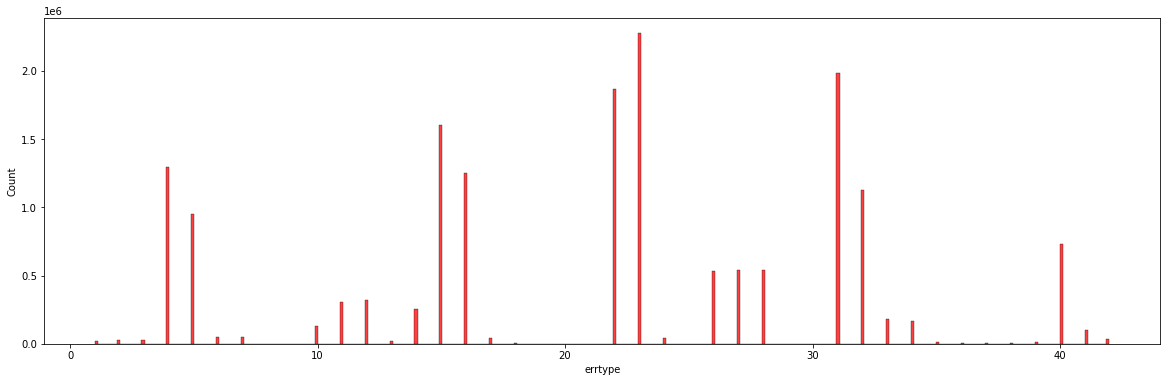

In [37]:
plt.figure(figsize=(20, 6))
sns.histplot(train_err["errtype"], color="RED")


<AxesSubplot:xlabel='errtype', ylabel='Count'>

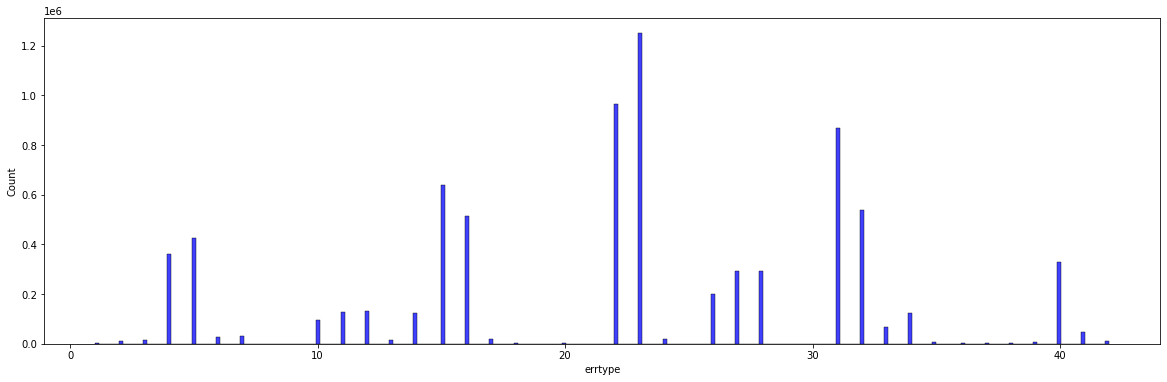

In [125]:
plt.figure(figsize=(20, 6))
sns.histplot(err_prob_user["errtype"], color="BLUE")



<AxesSubplot:xlabel='errtype', ylabel='Count'>

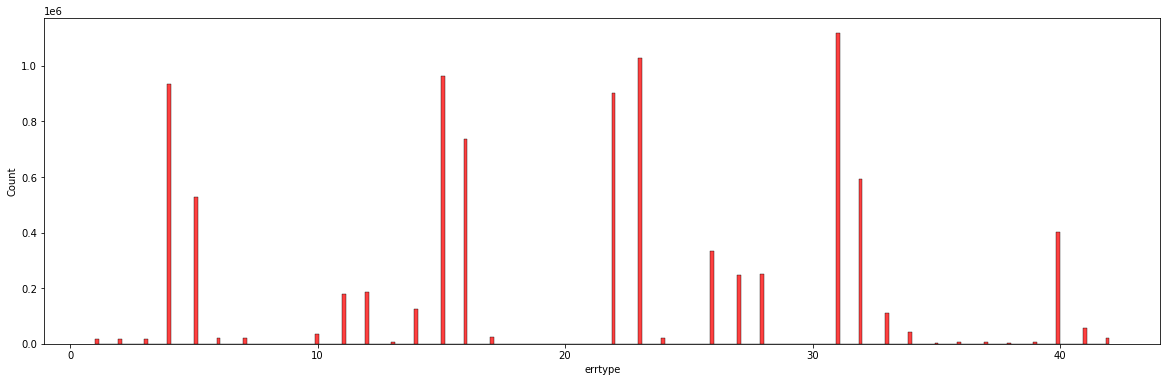

In [130]:
plt.figure(figsize=(20, 6))
sns.histplot(err_not_prob_user["errtype"], color="RED")





In [143]:
# 불만접수된 횟수/전체 에러 발생횟수 

# Errtype만으로는 구분하기 힘들다.? 
# Errcode는 세분화되어있다. ->
# Errtype 과 errcode 분석... 
# Errcode
# Todo 그래프 비율 -> 불만접수된 횟수/전체 에러 발생횟수 

In [145]:
train_prob.user_id.nunique()

5000

In [147]:
train_err.user_id.nunique()

15000

In [149]:
problem_per = (train_prob.user_id.nunique()/train_err.user_id.nunique())*100
print(f"불만을 접수한 사람의 비율 : {problem_per}%")

불만을 접수한 사람의 비율 : 33.33333333333333%


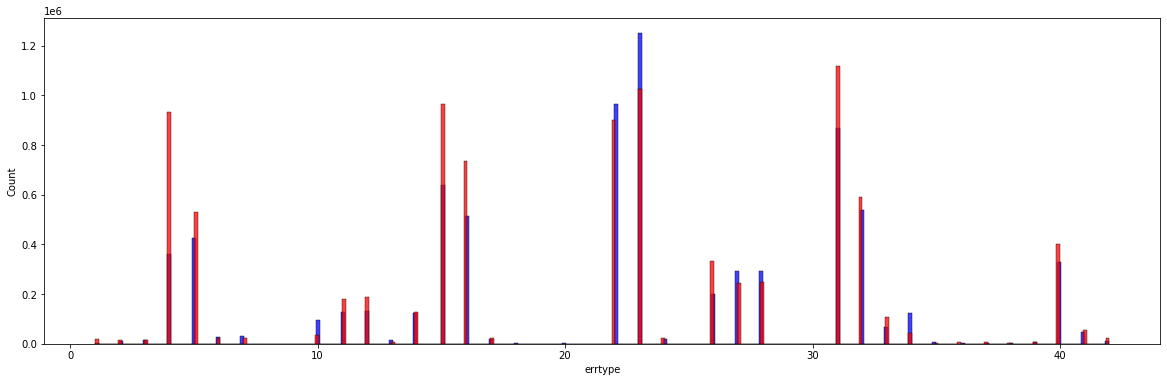

In [174]:
plt.figure(figsize=(20, 6))
sns.histplot(err_prob_user["errtype"], color="BLUE")
sns.histplot(err_not_prob_user["errtype"], color="RED")

plt.show() 




#### ERROR Code 살펴보기

In [179]:
train_err.errcode.nunique()

2805

In [181]:
train_err.head()

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,2020-11-01 02:56:16,model_3,05.15.2138,15,1
1,10000,2020-11-01 03:03:09,model_3,05.15.2138,12,1
2,10000,2020-11-01 03:03:09,model_3,05.15.2138,11,1
3,10000,2020-11-01 05:05:14,model_3,05.15.2138,16,1
4,10000,2020-11-01 05:05:15,model_3,05.15.2138,4,0


In [183]:
train_prob.head()

,user_id,time
0,10001,2020-11-13 19:00:00
1,10004,2020-11-04 12:00:00
2,10005,2020-11-13 12:00:00
3,10006,2020-11-10 17:00:00
4,10006,2020-11-10 18:00:00


In [207]:
temp = err_prob_user.loc[err_prob_user.user_id==10001]
temp

,user_id,time,model_nm,fwver,errtype,errcode
317,10001,2020-11-01 02:04:15,model_2,04.33.1185,15,1
318,10001,2020-11-01 02:04:15,model_2,04.33.1185,15,1
319,10001,2020-11-01 02:04:15,model_2,04.33.1185,31,1
320,10001,2020-11-01 02:04:15,model_2,04.33.1185,33,2
321,10001,2020-11-01 02:04:21,model_2,04.33.1185,12,1
...,...,...,...,...,...,...
16554088,10001,2020-11-29 05:08:46,model_0,04.22.1778,15,1
16554089,10001,2020-11-30 13:26:04,model_0,04.22.1778,16,1
16554090,10001,2020-11-30 13:26:24,model_0,04.22.1778,31,0
16554091,10001,2020-11-30 21:03:51,model_0,04.22.1778,40,1


In [210]:
temp.time.nunique()

2315836

#### 모델 별 불만 제기율

In [222]:
cut = temp.model_nm.unique()

In [213]:
temp.loc[temp.model_nm=="model_2"]

,user_id,time,model_nm,fwver,errtype,errcode
317,10001,2020-11-01 02:04:15,model_2,04.33.1185,15,1
318,10001,2020-11-01 02:04:15,model_2,04.33.1185,15,1
319,10001,2020-11-01 02:04:15,model_2,04.33.1185,31,1
320,10001,2020-11-01 02:04:15,model_2,04.33.1185,33,2
321,10001,2020-11-01 02:04:21,model_2,04.33.1185,12,1
...,...,...,...,...,...,...
16546469,10001,2020-11-30 22:45:00,model_2,04.33.1261,15,1
16546470,10001,2020-11-30 22:45:03,model_2,04.33.1261,16,1
16546471,10001,2020-11-30 22:45:04,model_2,04.33.1261,31,1
16546472,10001,2020-11-30 22:45:23,model_2,04.33.1261,31,0


In [277]:
err_prob_user = err_prob_user.sort_values('model_nm')

In [268]:
err_not_prob_user = err_not_prob_user.sort_values('model_nm')

In [269]:
train_err = train_err.sort_values('model_nm')

<AxesSubplot:xlabel='model_nm', ylabel='Count'>

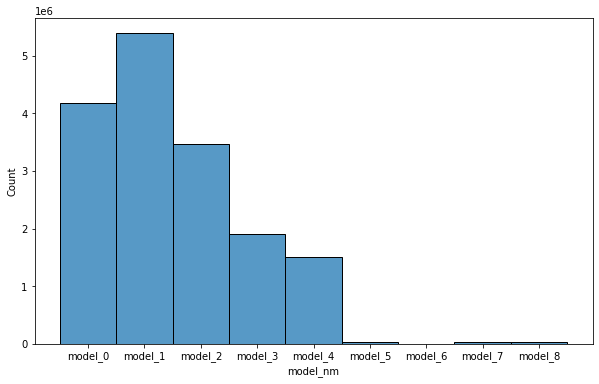

In [278]:
plt.figure(figsize=(10, 6))
sns.histplot(train_err.model_nm)

<AxesSubplot:xlabel='model_nm', ylabel='Count'>

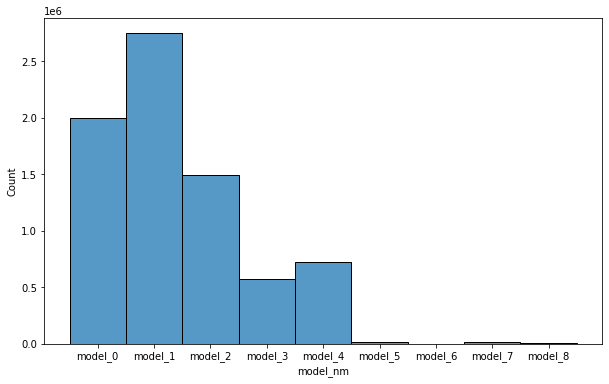

In [279]:
plt.figure(figsize=(10, 6))
sns.histplot(err_prob_user.model_nm)

<AxesSubplot:xlabel='model_nm', ylabel='Count'>

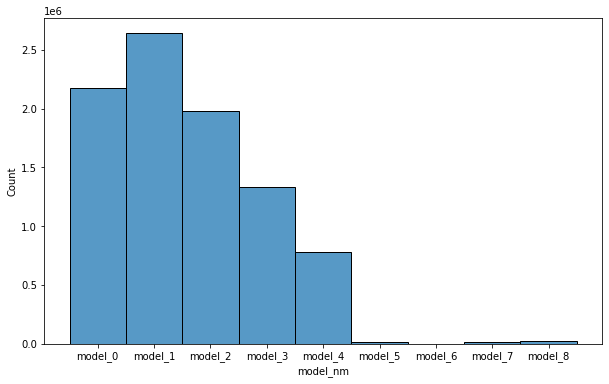

In [280]:
plt.figure(figsize=(10, 6))
sns.histplot(err_not_prob_user.model_nm)

In [321]:
train_err["user_id"].loc[train_err["model_nm"]==f"model_0"].nunique()

4360

In [323]:
train_err["fwver"].nunique()

37

In [296]:
train_err["user_id"].loc[train_err["model_nm"]==f"model_0"].count()

4176279

In [297]:
train_err_modelnm = []
for i in range(train_err["model_nm"].nunique()):
    train_err_modelnm.append(train_err["user_id"].loc[train_err["model_nm"]==f"model_{i}"].count())
    print(f"model_{i} = {train_err_modelnm[i]}")
train_err_modelnm

model_0 = 4176279
model_1 = 5384491
model_2 = 3473254
model_3 = 1907438
model_4 = 1507802
model_5 = 32233
model_6 = 1746
model_7 = 35356
model_8 = 36064


[4176279, 5384491, 3473254, 1907438, 1507802, 32233, 1746, 35356, 36064]

In [298]:
err_prob_user_modelnm = []
for i in range(err_prob_user["model_nm"].nunique()):
    err_prob_user_modelnm.append(err_prob_user["user_id"].loc[err_prob_user["model_nm"]==f"model_{i}"].count())
    print(f"model_{i} = {err_prob_user_modelnm[i]}")
err_prob_user_modelnm

model_0 = 2002046
model_1 = 2746298
model_2 = 1494037
model_3 = 570153
model_4 = 729197
model_5 = 15268
model_6 = 130
model_7 = 18740
model_8 = 12912


[2002046, 2746298, 1494037, 570153, 729197, 15268, 130, 18740, 12912]

In [299]:
err_not_prob_user_modelnm = []
for i in range(err_not_prob_user["model_nm"].nunique()):
    err_not_prob_user_modelnm.append(err_not_prob_user["user_id"].loc[err_not_prob_user["model_nm"]==f"model_{i}"].count())
    print(f"model_{i} = {err_not_prob_user_modelnm[i]}")
err_not_prob_user_modelnm

model_0 = 2174233
model_1 = 2638193
model_2 = 1979217
model_3 = 1337285
model_4 = 778605
model_5 = 16965
model_6 = 1616
model_7 = 16616
model_8 = 23152


[2174233, 2638193, 1979217, 1337285, 778605, 16965, 1616, 16616, 23152]

In [313]:
# 각 모델별 불만 제기 비율
problem_rate_bymodelnm={}
for i in range(train_err["model_nm"].nunique()):
    rate = err_prob_user_modelnm[i]/train_err_modelnm[i] * 100
    problem_rate_bymodelnm[f"model_{i}"] = rate
    print(f"model_{i}: {rate:.2f} %")
print(problem_rate_bymodelnm)

model_0: 47.94 %
model_1: 51.00 %
model_2: 43.02 %
model_3: 29.89 %
model_4: 48.36 %
model_5: 47.37 %
model_6: 7.45 %
model_7: 53.00 %
model_8: 35.80 %
{'model_0': 47.93851177088504, 'model_1': 51.00385533191532, 'model_2': 43.01548346305798, 'model_3': 29.891037087443994, 'model_4': 48.36158859054438, 'model_5': 47.36760462879657, 'model_6': 7.445589919816724, 'model_7': 53.003733454010636, 'model_8': 35.80301685891748}


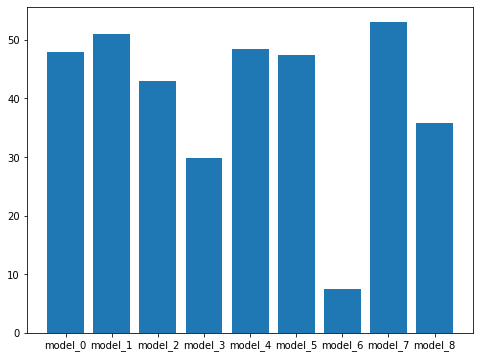

In [319]:
plt.figure(figsize=(8, 6))
plt.bar(problem_rate_bymodelnm.keys(), problem_rate_bymodelnm.values())
plt.show()

#### 불만 접수한 고객과 접수하지 않은 고객의 errortype 비율 

In [325]:
err_prob_user.head()

,user_id,time,model_nm,fwver,errtype,errcode
6643753,15989,2020-11-28 00:44:10,model_0,04.22.1778,22,1
1982772,11875,2020-11-29 02:29:45,model_0,04.22.1778,5,B-A8002
1982795,11875,2020-11-29 02:30:04,model_0,04.22.1778,5,B-A8002
1982797,11875,2020-11-29 02:44:07,model_0,04.22.1778,40,1
1982928,11875,2020-11-29 10:34:51,model_0,04.22.1778,5,B-A8002


In [327]:
err_prob_user.errtype.nunique()

41

In [329]:
err_prob_user.errtype.unique()

array([22,  5, 40, 31, 26, 16, 15, 12, 11, 33, 23, 24, 42, 41, 37, 17, 36,
       14, 39, 35,  7, 13, 30, 27, 28, 34,  6,  4, 10, 18,  2, 20,  1, 25,
       38, 21, 19, 32,  8,  9,  3])

In [349]:
err_prob_user.errtype.value_counts()

23    1250243
22     964736
31     868235
15     640140
32     538238
16     513531
5      423956
4      363153
40     327526
28     294513
27     294144
26     202030
12     132926
11     126391
14     125541
34     122748
10      96989
33      69366
41      48787
7       30025
6       28187
17      21257
24      17646
13      16363
3       13940
42      11905
2        9310
39       8819
35       7406
1        4016
37       3874
36       3860
38       2349
18       2339
20       1809
25       1060
19        554
21        506
30        281
9          54
8          28
Name: errtype, dtype: int64

In [357]:
cnt_err_prob_errtype = err_prob_user.errtype.value_counts()

<AxesSubplot:>

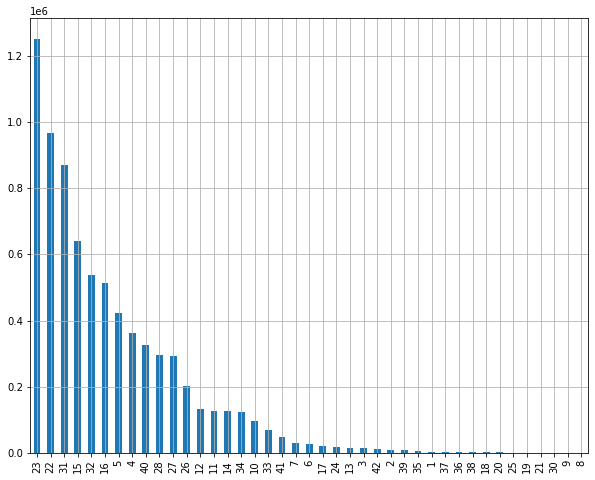

In [369]:
cnt_err_prob_errtype = pd.value_counts(err_prob_user['errtype'].values, sort=True)
cnt_err_prob_errtype.plot.bar()
cnt_err_prob_errtype.plot.bar(grid=True, figsize=(10,8), fontsize=10)  # figsize, fontsize 조정

In [416]:
cnt_err_prob_errtype = err_prob_user.errtype.value_counts(sort=True).rename_axis('errtype').reset_index(name='errtype_counts')

cnt_err_prob_errtype

,errtype,errtype_counts
0,23,1250243
1,22,964736
2,31,868235
3,15,640140
4,32,538238
5,16,513531
6,5,423956
7,4,363153
8,40,327526
9,28,294513


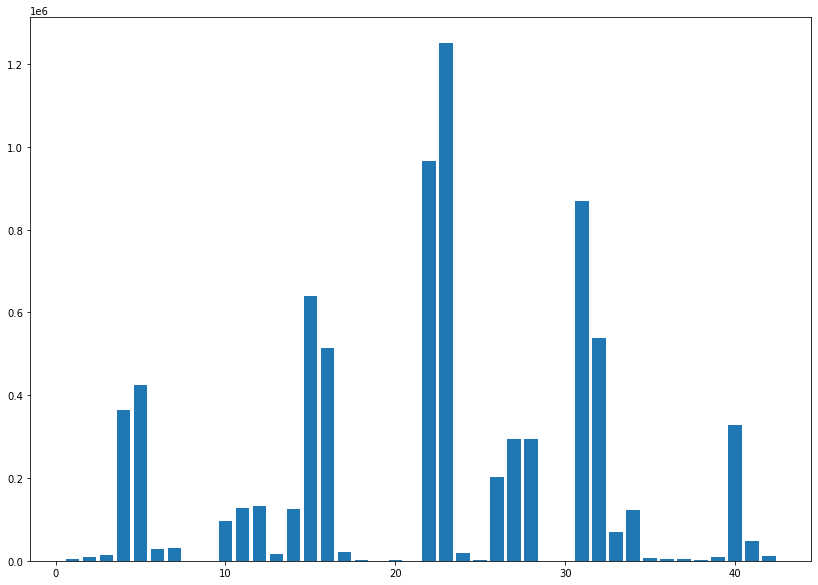

In [418]:
plt.figure(figsize=(14, 10))
plt.bar(cnt_err_prob_errtype.errtype, cnt_err_prob_errtype.errtype_counts)
# cnt_err_prob_errtype.plot.bar(x="errcode", y="counts")
plt.show()

In [432]:
cnt_err_all_errtype = train_err.errtype.value_counts(sort=True).rename_axis('errtype').reset_index(name='all_errtype_counts')

In [433]:
display(cnt_err_all_errtype, cnt_err_prob_errtype)

,errtype,all_errtype_counts
0,23,2276515
1,31,1985294
2,22,1865361
3,15,1604951
4,4,1296750
5,16,1249376
6,32,1130564
7,5,952920
8,40,730378
9,28,544306


,errtype_counts
errtype,
23,1250243
22,964736
31,868235
15,640140
32,538238
16,513531
5,423956
4,363153
40,327526


In [435]:
cnt_err_all_errtype.set_index("errtype", inplace=True)
# cnt_err_prob_errtype.set_index("errtype", inplace=True)

In [438]:
display(cnt_err_all_errtype, cnt_err_prob_errtype)

,all_errtype_counts
errtype,
23,2276515
31,1985294
22,1865361
15,1604951
4,1296750
16,1249376
32,1130564
5,952920
40,730378


,errtype_counts
errtype,
23,1250243
22,964736
31,868235
15,640140
32,538238
16,513531
5,423956
4,363153
40,327526


In [443]:
temp = pd.merge( cnt_err_prob_errtype, cnt_err_all_errtype, how='outer', on='errtype')
temp

,errtype_counts,all_errtype_counts
errtype,,
23,1250243,2276515
22,964736,1865361
31,868235,1985294
15,640140,1604951
32,538238,1130564
16,513531,1249376
5,423956,952920
4,363153,1296750
40,327526,730378


In [449]:
for i in range(len(temp)):
     cnt_err_prob_errtype[]

41

In [267]:
train_err.head()

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,2020-11-01 02:56:16,model_3,05.15.2138,15,1
1,10000,2020-11-01 03:03:09,model_3,05.15.2138,12,1
2,10000,2020-11-01 03:03:09,model_3,05.15.2138,11,1
3,10000,2020-11-01 05:05:14,model_3,05.15.2138,16,1
4,10000,2020-11-01 05:05:15,model_3,05.15.2138,4,0


In [141]:
train_err.model_nm.unique()

array(['model_3', 'model_2', 'model_0', 'model_1', 'model_7', 'model_4',
       'model_5', 'model_8', 'model_6'], dtype=object)

In [73]:
prob_user_id = err_prob_user.user_id.unique()

In [87]:
prob_user_id

array([10001, 10004, 10005, ..., 24990, 24997, 24998])

In [88]:
err_prob_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7588781 entries, 317 to 16554092
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   int64 
 1   time      object
 2   model_nm  object
 3   fwver     object
 4   errtype   int64 
 5   errcode   object
dtypes: int64(2), object(4)
memory usage: 663.3+ MB


In [95]:
# how = {
#     "errcode" : np.max
# }
err_prob_user.groupby(["user_id"]).agg('errtype')

### train_prob 데이터셋 살펴보기


In [45]:
train_prob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5429 non-null   int64 
 1   time     5429 non-null   object
dtypes: int64(1), object(1)
memory usage: 85.0+ KB


In [46]:
train_prob.head()

,user_id,time
0,10001,2020-11-13 19:00:00
1,10004,2020-11-04 12:00:00
2,10005,2020-11-13 12:00:00
3,10006,2020-11-10 17:00:00
4,10006,2020-11-10 18:00:00
